# Lesson 1 - Image Classification

*by Alex Han, inspired heavily by fast.ai's own instructive [notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) on the topic*

In this Jupyter notebook, we will build a model to classify images of butterflies into one of 10 categories (see image below). The dataset we'll be using is Josiah Wang's [Leeds Butterfly Dataset](http://www.josiahwang.com/dataset/leedsbutterfly/).

![The 10 butterflies we'll classify](10-leeds-butterflies.png)

## Preamble

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Downloading the Data

In [86]:
from os import getcwd
path = Path(getcwd())
path

PosixPath('/home/paperspace/fastai/1-image-classification')

In [3]:
url = "http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip"
filename = "leedsbutterfly_dataset_v1.0.zip"
download_url(url, path/filename)

In [12]:
path.ls()

[PosixPath('/home/paperspace/fastai/1-image-classification/.ipynb_checkpoints'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly_dataset_v1.0.zip'),
 PosixPath('/home/paperspace/fastai/1-image-classification/butterflies.ipynb')]

In [15]:
from zipfile import ZipFile
with ZipFile(path/filename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [16]:
path.ls()

[PosixPath('/home/paperspace/fastai/1-image-classification/.ipynb_checkpoints'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly_dataset_v1.0.zip'),
 PosixPath('/home/paperspace/fastai/1-image-classification/butterflies.ipynb')]

In [27]:
path = path/"leedsbutterfly"
path.ls()

[PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/descriptions'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/segmentations'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/README.txt')]

In [29]:
path_img = path/"images"
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/0070076.png'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/0030002.png'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/0020024.png'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/0040018.png'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/0080031.png')]

## Reorganizing the Data

In the [dataset](http://www.josiahwang.com/dataset/leedsbutterfly/), we see that the naming scheme of the images denotes the type of butterfly in the first three digits of each file name. With respect to the topmost image in the notebook, class `001` corresponds to the top-left *Danaus plexippus*, and class `010` corresponds to the bottom-right *Vanessa cardui*. Let's write a utility function to move each image into their respective folders for clearer organization.

In [94]:
# Moves images 001XXXX.png to subdirectory 001/ and so forth

from os import makedirs, path as osPath # naming conflict with `path` variable name
from shutil import move

for img in fnames:
    label = str(img)[-11:-8] # get the leading 3 digits of each image name
    subdir = path_img/label
    if not osPath.exists(subdir):
        makedirs(subdir)
        move(str(img), subdir)

In [32]:
path_img.ls()

[PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/001'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/007'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/004'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/008'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/006'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/010'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/002'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/009'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/005'),
 PosixPath('/home/paperspace/fastai/1-image-classification/leedsbutterfly/images/003')]

In [33]:
np.random.seed(2)

In [34]:
data = (ImageList.from_folder(path_img)
                   .split_subsets(train_size=0.8,valid_size=0.2)
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
       )

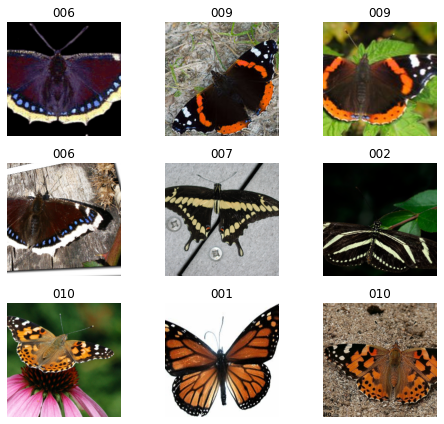

In [36]:
data.show_batch(rows=3, figsize=(7,6))

In [37]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010'],
 10,
 665,
 166)

## Training the Model

In [38]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# learn.model

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.331531,0.543600,0.174699,01:00
1,1.149701,0.221909,0.078313,00:58
2,0.711997,0.085198,0.036145,01:05
3,0.501130,0.061290,0.018072,01:00


A basic model like this is already able to achieve **94%** accuracy. Not bad!

In [40]:
learn.save("stage-1")

## Finding a Better Learning Rate

The validation loss is trending downwards, suggesting the learning rate is getting closer to optimal, so let's train another 4 cycles.

In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.045903,0.040611,0.024096,01:02
1,0.060040,0.098592,0.030120,01:01
2,0.063640,0.022458,0.006024,01:00
3,0.053547,0.005351,0.000000,01:13


In [63]:
learn.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (665 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
005,008,006,007,004
Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Valid: LabelList (166 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
009,007,005,009,006
Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


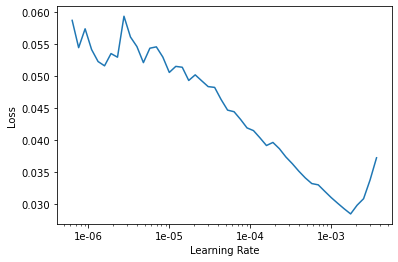

In [49]:
learn.recorder.plot()

In [64]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.026678,0.015178,0.006024,01:28
1,0.037066,0.015256,0.012048,01:40
2,0.030259,0.038329,0.006024,01:40
3,0.026028,0.041989,0.006024,01:39


It appears best results are achieved after just 2 more epochs.

In [66]:
learn.load("stage-1")
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.038125,0.010772,0.006024,01:44
1,0.024086,0.003794,0.000000,01:45


In [67]:
learn.save("stage-2")

## Interpretation

In [68]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (665 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
005,008,006,007,004
Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Valid: LabelList (166 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
009,007,005,009,006
Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [69]:
interp = ClassificationInterpretation.from_learner(learn)

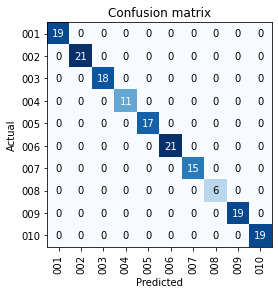

In [70]:
interp.plot_confusion_matrix()
# doc(ClassificationInterpretation.plot_confusion_matrix)

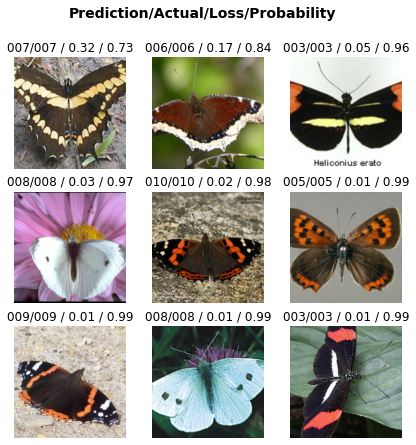

In [71]:
interp.plot_top_losses(9, figsize=(7,7))

## Cleaning Up

Our classifier appears to be doing very well, even for the `top_losses`, suggesting cleaning of the data may be optional.

In [72]:
from fastai.widgets import *

In [73]:
db_clean = (ImageList.from_folder(path_img)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
           )

In [74]:
learn_cln = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

In [75]:
learn_cln.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (832 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
001,001,001,001,001
Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [78]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln, n_imgs=10)

In [79]:
ImageCleaner(ds, idxs, path_img)

'No images to show :)'

From the top 10 losses, we deleted the following image in the first batch of 5.

![deleted image](cleaned-batch.png)

Save changes made by `ImageCleaner`, using the `.csv` written to `path_img`.

In [83]:
db_clean = (ImageList.from_csv(path_img, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
           )

In [84]:
learn_cln = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

In [85]:
learn_cln.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (831 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/paperspace/fastai/1-image-classification/leedsbutterfly/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU

## Exporting the Model

In [87]:
learn_cln.export(file = path/"export.pkl")

In [88]:
defaults.device = torch.device("cpu")

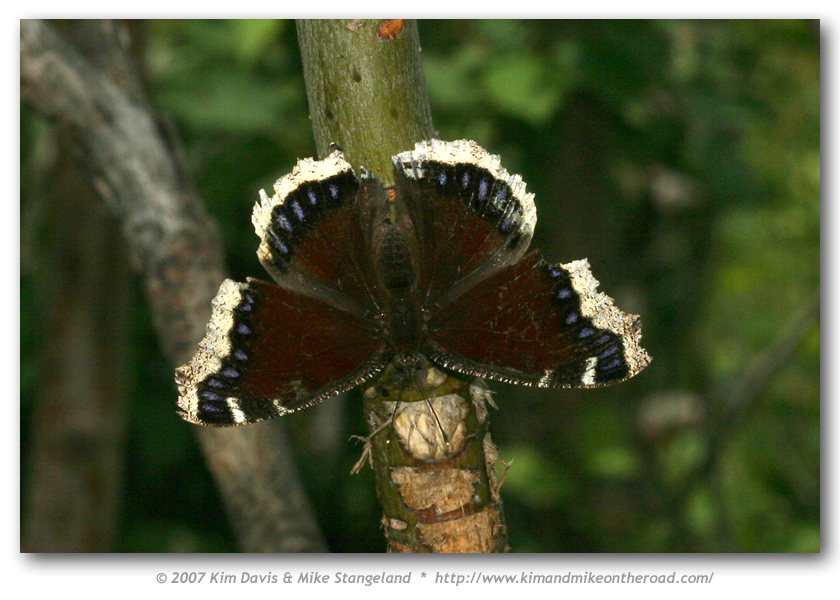

In [89]:
img = open_image(path_img/"006"/"0060007.png")
img

In [90]:
learn_cln = load_learner(path)

In [91]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'006'

Our sample image has been correctly classified as `006`, or *Nymphalis antiopa*, and it looks like our model (saved to `path/export.pkl`) is good to go!